# Magnetic Models Comparison

In this tutorial, we'll compare various **Magnetic Models**.

## Setup

Let's import the necessary libraries:

In [1]:
import math

import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import DateTime
from ostk.physics.environment.objects.celestial_bodies import Earth
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel

## Comparison

Let's set up some magnetic models:

In [2]:
magnetic_models = {
    EarthMagneticModel.Type.Dipole: None,
    EarthMagneticModel.Type.EMM2010: None,
    EarthMagneticModel.Type.EMM2015: None,
    EarthMagneticModel.Type.EMM2017: None,
    EarthMagneticModel.Type.IGRF11: None,
    EarthMagneticModel.Type.IGRF12: None,
    EarthMagneticModel.Type.WMM2010: None,
    EarthMagneticModel.Type.WMM2015: None,
}

In [3]:
earth = Earth.default()

In [4]:
def init_magnetic_models(magnetic_models):
    for key in magnetic_models:
        if magnetic_models[key] is None:
            magnetic_models[key] = EarthMagneticModel(key)


init_magnetic_models(magnetic_models)

In [5]:
instant = Instant.date_time(DateTime(2015, 1, 1, 0, 0, 0), Scale.UTC)

In [6]:
def calc_B_2d(magnetic_model, X, Z):
    size_x = len(X)
    size_z = len(X[0])

    size = size_x * size_z

    Bx = np.zeros(size)
    Bz = np.zeros(size)

    earth_radius_m = earth.get_equatorial_radius().in_meters()

    i = 0

    for x, z in np.vstack([X.ravel(), Z.ravel()]).T:
        if math.sqrt(pow(abs(x), 2) + pow(abs(z), 2)) < earth_radius_m:
            Bx[i] = 0.0
            Bz[i] = 0.0

        else:
            try:
                b = magnetic_model.get_field_value_at(np.array((x, 0.0, z)), instant).T

                bx = b[0]
                bz = b[2]

                Bx[i] = bx
                Bz[i] = bz

            except Exception as e:
                print(e)

                print("x = {}".format(x))
                print("z = {}".format(z))

                raise e

        i += 1

    return Bx.reshape(size_x, size_z), Bz.reshape(size_x, size_z)

In [7]:
def calc_B_3d(magnetic_model, X, Y, Z):
    size_x = len(X)
    size_y = len(X[0])
    size_z = len(X[0][0])

    size = size_x * size_y * size_z

    Bx = np.zeros(size)
    By = np.zeros(size)
    Bz = np.zeros(size)

    earth_radius_m = earth.get_equatorial_radius().in_meters()

    i = 0

    for x, y, z in np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T:
        if math.sqrt(pow(abs(x), 2) + pow(abs(y), 2) + pow(abs(z), 2)) < earth_radius_m:
            Bx[i] = 0.0
            By[i] = 0.0
            Bz[i] = 0.0

        else:
            try:
                b = magnetic_model.get_field_value_at(np.array((x, y, z)), instant).T

                bx = b[0]
                by = b[1]
                bz = b[2]

                Bx[i] = bx
                By[i] = by
                Bz[i] = bz

            except Exception as e:
                print(e)

                print("x = {}".format(x))
                print("y = {}".format(y))
                print("z = {}".format(z))

                raise e

        i += 1

    return (
        Bx.reshape(size_x, size_y, size_z),
        By.reshape(size_x, size_y, size_z),
        Bz.reshape(size_x, size_y, size_z),
    )

## Display

2D plot:

In [8]:
lim = 100000e3

xlim = (-lim, +lim)
zlim = (-lim, +lim)

(nx, nz) = 64, 64

x = np.linspace(xlim[0], xlim[1], nx)
z = np.linspace(zlim[0], zlim[1], nz)

(X, Z) = np.meshgrid(x, z)

(Bx, Bz) = calc_B_2d(magnetic_models[EarthMagneticModel.Type.EMM2015], X, Z)

/tmp/ipykernel_3907/1284092256.py:11: RuntimeWarning: divide by zero encountered in log
  color = 2 * np.log(np.hypot(Bx, Bz))


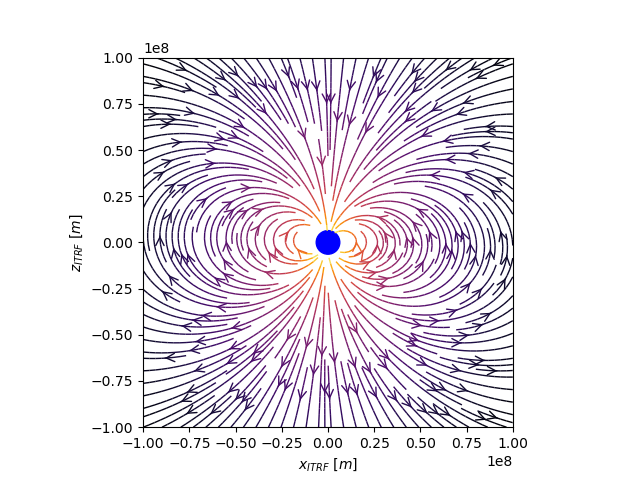

In [9]:
figure = plt.figure()

ax = figure.add_subplot(111)

# Plot Earth circle

ax.add_artist(Circle((0.0, 0.0), earth.get_equatorial_radius().in_meters(), color="b"))

# Plot B field

color = 2 * np.log(np.hypot(Bx, Bz))

ax.streamplot(
    x,
    z,
    Bx,
    Bz,
    color=color,
    linewidth=1,
    cmap=plt.cm.inferno,
    density=2,
    arrowstyle="->",
    arrowsize=1.5,
)

ax.set_xlabel("$x_{ITRF}\ [m]$")
ax.set_ylabel("$z_{ITRF}\ [m]$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(zlim[0], zlim[1])
ax.set_aspect("equal")

plt.show()

3D plot:

In [10]:
lim = 10000e3

xlim = (-lim, +lim)
ylim = (-lim, +lim)
zlim = (-lim, +lim)

(nx, ny, nz) = (9, 9, 9)

x = np.linspace(xlim[0], xlim[1], nx)
y = np.linspace(ylim[0], ylim[1], ny)
z = np.linspace(zlim[0], zlim[1], nz)

(X, Y, Z) = np.meshgrid(x, y, z)

(Bx, By, Bz) = calc_B_3d(magnetic_models[EarthMagneticModel.Type.EMM2010], X, Y, Z)

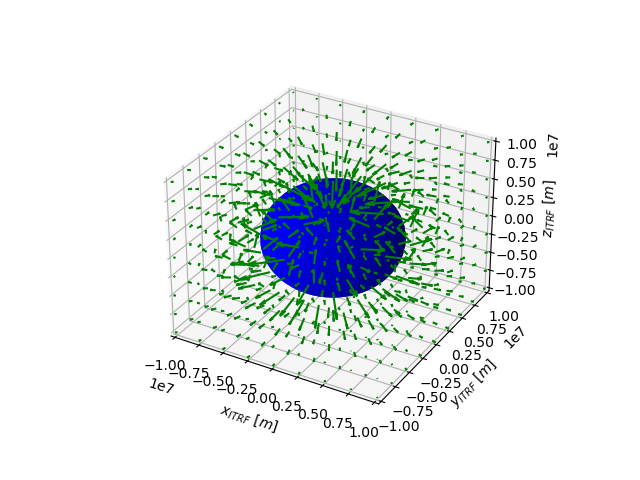

In [11]:
figure = plt.figure()

ax = figure.add_subplot(projection="3d")

# Plot Earth sphere

u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)

earth_radius_m = float(earth.get_equatorial_radius().in_meters())

x = earth_radius_m * np.outer(np.cos(u), np.sin(v))
y = earth_radius_m * np.outer(np.sin(u), np.sin(v))
z = earth_radius_m * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, rstride=4, cstride=4, color="b", linewidth=0, alpha=1)

# Plot B field

ax.quiver(X, Y, Z, Bx, By, Bz, length=1e11, color="g")

ax.set_xlabel("$x_{ITRF}\ [m]$")
ax.set_ylabel("$y_{ITRF}\ [m]$")
ax.set_zlabel("$z_{ITRF}\ [m]$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.set_zlim(zlim[0], zlim[1])

plt.show()

---